In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from scipy.optimize import curve_fit
from scipy.stats import variation
from statistics import mean, median

Paste your 96 well format OD data from Excel between the upper ''' and lower '''.

In [2]:
rawData = '''
1.97	0.045	0.068	0.568	0.207	0	0	0	0	0	0	0
1.936	0.036	0.052	0.574	0.189	0	0	0	0	0	0	0
1.514	0.245	0.72	0.205	0	0	0	0	0	0	0	0
1.574	0.271	0.775	0.228	0	0	0	0	0	0	0	0
0.688	1.182	1.165	1.392	0	0	0	0	0	0	0	0
0.695	1.191	1.201	1.433	0	0	0	0	0	0	0	0
0.222	0.815	0.42	0.241	0	0	0	0	0	0	0	0
0.239	0.868	0.444	0.21	0	0	0	0	0	0	0	0
'''
row_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
column_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

plateTemplate = pd.DataFrame(index = row_list, columns = column_list)

rawData = pd.read_table(io.StringIO(rawData), delim_whitespace=True, names=plateTemplate.columns)
rawData.index = plateTemplate.index
rawData

,1,2,3,4,5,6,7,8,9,10,11,12
A,1.970,0.045,0.068,0.568,0.207,0,0,0,0,0,0,0
B,1.936,0.036,0.052,0.574,0.189,0,0,0,0,0,0,0
C,1.514,0.245,0.720,0.205,0.000,0,0,0,0,0,0,0
D,1.574,0.271,0.775,0.228,0.000,0,0,0,0,0,0,0
E,0.688,1.182,1.165,1.392,0.000,0,0,0,0,0,0,0
F,0.695,1.191,1.201,1.433,0.000,0,0,0,0,0,0,0
G,0.222,0.815,0.420,0.241,0.000,0,0,0,0,0,0,0
H,0.239,0.868,0.444,0.210,0.000,0,0,0,0,0,0,0


Paste your 96 well format plate template between the upper ''' and lower '''.

In [3]:
plateLayout = '''
St01	St05	1860	2843	2586	x	x	x	x	x	x	x
St01	St05	1860	2843	2586	x	x	x	x	x	x	x
St02	Co01	9506	295	x	x	x	x	x	x	x	x
St02	Co01	9506	295	x	x	x	x	x	x	x	x
St03	Co02	2967	1883	x	x	x	x	x	x	x	x
St03	Co02	2967	1883	x	x	x	x	x	x	x	x
St04	6744	4191	2440	x	x	x	x	x	x	x	x
St04	6744	4191	2440	x	x	x	x	x	x	x	x
'''

plateLayout = pd.read_table(io.StringIO(plateLayout), delim_whitespace=True, names=plateTemplate.columns)
plateLayout.index = plateTemplate.index
plateLayout

,1,2,3,4,5,6,7,8,9,10,11,12
A,St01,St05,1860,2843,2586,x,x,x,x,x,x,x
B,St01,St05,1860,2843,2586,x,x,x,x,x,x,x
C,St02,Co01,9506,295,x,x,x,x,x,x,x,x
D,St02,Co01,9506,295,x,x,x,x,x,x,x,x
E,St03,Co02,2967,1883,x,x,x,x,x,x,x,x
F,St03,Co02,2967,1883,x,x,x,x,x,x,x,x
G,St04,6744,4191,2440,x,x,x,x,x,x,x,x
H,St04,6744,4191,2440,x,x,x,x,x,x,x,x


Check that the standards values listed below are correct.

In [4]:
# In the [] after pd.Series, input the standard concentrations. Number separated by a comma.
# In the [] after index=, input the corresponding labels for each standard. Labels in 'quotes' separated by a comma.
standardConc = pd.Series([840, 210, 52, 13, 0], index=['St01', 'St02', 'St03', 'St04', 'St05'], name='Conc')

In [5]:
wellID = []
sampleID = []
wellOD = []
for row_data in row_list:
    for column_data in column_list:
        wellID.append(row_data + column_data)
        sampleID.append(plateLayout.at[row_data, column_data])
        wellOD.append(rawData.at[row_data, column_data])

dataTable = pd.DataFrame({'Sample ID':sampleID, 'OD':wellOD}, index=wellID)

standardCurve = dataTable.groupby('Sample ID').mean()
standardCurve = pd.concat([standardConc, standardCurve], axis=1, join_axes=[standardConc.index])
standardCurve

,Conc,OD
St01,840,1.9530
St02,210,1.5440
St03,52,0.6915
St04,13,0.2305
St05,0,0.0405


In [6]:
x_list = standardCurve['Conc'].tolist()
y_list = standardCurve['OD'].tolist()

# This orders the coordinate pairs from lowest analyte concentration to highest.
standardCurve = sorted(zip(x_list, y_list))

# This strips out any 0s from the x and y lists and replaces them with 0.001.
x_list = [x_val if x_val != 0 else 0.001 for x_val in [x[0] for x in standardCurve]]
y_list = [y_val if y_val != 0 else 0.001 for y_val in [y[1] for y in standardCurve]]

[0.1, 8400, 0, 2.3436]

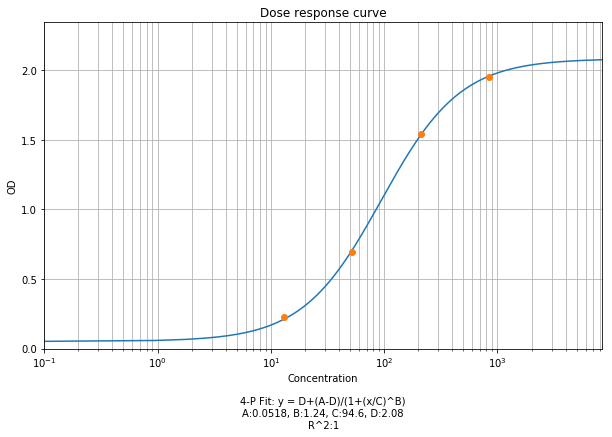

In [9]:
def logistic4(x, A, B, C, D):
    """4PL logistic equation."""
    return D + (A-D)/(1 + (x/C)**B)

def maxSlope(x_list, y_list):
    x_list = [math.log10(l) for l in [float(i) for i in x_list]]
    coordinates = zip(x_list, y_list)
    x_1, y_1 = 1, y_list[0] #Trying to make sure first calculation always has zero on top and non-zero on bottom
    slopeList = []
    for x_2, y_2 in coordinates:
        slopeList.append(abs((y_2 - y_1)/(x_2 - x_1))) #Parameter B should always be positive so using abs
        x_1, y_1 = x_2, y_2
    return(max(slopeList))

# Initial guess for parameters
p0 = [y_list[0], maxSlope(x_list,y_list), median(x_list), y_list[-1]]

# Fit equation using least squares optimization
popt, pcov = curve_fit(logistic4, x_list, y_list, p0, bounds=(0, np.inf))
#print(popt, pcov)
#print(curve_fit(logistic4, x_list, y_list, p0, bounds=(0, np.inf)))
#print(*popt)

# Calculate R^2
r_squared = (1 
             - sum([(y_meas - y_calc)**2 for y_meas, y_calc in zip(y_list, [logistic4(x_std, *popt) for x_std in x_list])])
             / sum([(y_meas - mean(y_list))**2 for y_meas in y_list]))

xCont = np.linspace(0.1, 10*max(x_list), 10000)
fittedData=[logistic4(xVal, *popt) for xVal in xCont]
fig1 = plt.figure(figsize=(10,6))
ax=fig1.add_subplot(1,1,1)
ax.plot(xCont, fittedData)
ax.set_ylabel("OD")
ax.set_xlabel("""Concentration

4-P Fit: y = D+(A-D)/(1+(x/C)^B)
A:{1:0.3g}, B:{2:0.3g}, C:{3:0.3g}, D:{4:0.3g}
R^2:{0:0.3g}""".format(r_squared, *popt))
ax.grid(True, which='both')
ax.set_title("Dose response curve")
plt.xscale('log')
plt.plot(x_list, y_list, 'o')
plt.axis([0.1, 10*max(x_list), 0, 1.2*max(y_list)])